<a href="https://colab.research.google.com/github/DanielDekhtyar/AI-Accelerator/blob/main/Final%20Project/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# Importing the data about NYSE:SPY for the same period that we have news data about
snp = yf.download("SPY", start = '2009-02-14', end = '2020-06-11')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Removing the 'Ticker' column level leaving only the 'Price' level
# The 'Ticker' level has no valuable information because all the information in this DF is about the same ticker
snp.columns = snp.columns.get_level_values(0)

snp

Price,Close,High,Low,Open,Volume
Date,,,,,
2009-02-17,58.773655,61.548375,58.736557,59.471047,478910100
2009-02-18,58.632664,59.307799,58.076236,59.196512,362964800
2009-02-19,58.002090,59.463643,57.883383,59.233649,316867500
2009-02-20,57.438236,58.120787,56.214093,56.926326,477176600
2009-02-23,55.383156,58.068846,55.338638,58.068846,379641400
...,...,...,...,...,...
2020-06-04,290.366974,291.896413,288.240701,290.133830,75794400
2020-06-05,297.808868,299.608734,295.775859,295.841146,150524700
2020-06-08,301.408661,301.604494,298.079357,298.629573,73641200


In [4]:
# This is a CSV with around 1.4 million financial news articles from Feb 2009 to June 2020
news = pd.read_csv('analyst_ratings_processed.csv')
news

,title,date,stock
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...
1048570,uniQure Announces 36 Weeks of Follow-Up Data f...,2019-07-06 07:36:00-04:00,QURE
1048571,The Daily Biotech Pulse: FDA Approves Karyopha...,2019-07-05 08:55:00-04:00,QURE
1048572,The Week Ahead In Biotech: Pending Clinical Re...,2019-06-29 08:25:00-04:00,QURE
1048573,60 Biggest Movers From Yesterday,2019-06-25 05:12:00-04:00,QURE


In [5]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1048575 non-null  object
 1   date    1047605 non-null  object
 2   stock   1046635 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [6]:
# There aren't that many NaNs so we decided to just drop all the rows with any NaNs
news.dropna(how='any', axis=0, inplace=True)

In [7]:
# Change the "data" column into DateTime datatype
news["date"] = pd.to_datetime(news["date"], utc=True)

In [8]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046635 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype              
---  ------  --------------    -----              
 0   title   1046635 non-null  object             
 1   date    1046635 non-null  datetime64[ns, UTC]
 2   stock   1046635 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 31.9+ MB


In [9]:
# Sort the data by the date the news articles were published. Older articles first
news.sort_values(by='date', inplace=True)
news

,title,date,stock
871908,How Treasuries and ETFs Work,2009-02-14 19:02:00+00:00,NAV
514182,Update on the Luxury Sector: 2nd Quarter 2009,2009-04-27 18:39:00+00:00,FT
1828,Going Against the Herd,2009-04-29 12:48:00+00:00,A
64705,Charles Sizemore Radio Interview Saturday Morning,2009-05-22 18:28:00+00:00,AM
703606,"JVA perks to 39% gain, SMCG ready, MRM to cont...",2009-05-27 07:32:00+00:00,JVA
...,...,...,...
1031825,PVH Q1 Adj. EPS $(3.03) Misses $(1.28) Estimat...,2020-06-11 20:15:00+00:00,PVH
1031824,PVH: Q1 Earnings Insights,2020-06-11 20:24:00+00:00,PVH
1031823,PVH shares are trading lower after the company...,2020-06-11 20:25:00+00:00,PVH
1031822,7 Stocks Moving In Thursday's After-Hours Session,2020-06-11 20:49:00+00:00,PVH


EDA SNP DataFrame

In [10]:
snp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2849 entries, 2009-02-17 to 2020-06-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2849 non-null   float64
 1   High    2849 non-null   float64
 2   Low     2849 non-null   float64
 3   Open    2849 non-null   float64
 4   Volume  2849 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 133.5 KB


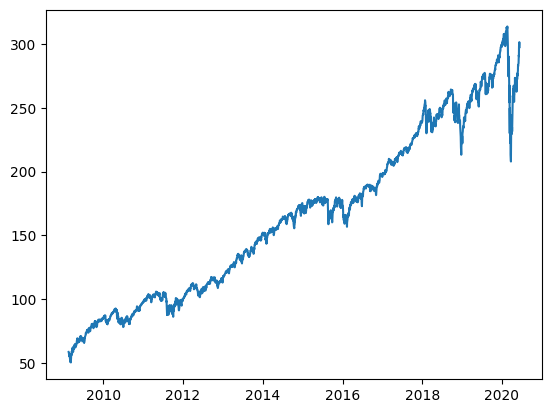

In [11]:
# See the stock price
plt.plot(snp['Close'])

In [12]:
snp['Close'].values.mean()

np.float64(164.44213040915236)

EDA news DataFrame

In [13]:
# Removing any stopwords and doing lemmatization on the news titles ('title') text

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    words = word_tokenize(str(text).lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Create a new column in the 'news' DataFrame, and add there all the article titles after they were cleaned and preprocessed
news['clean_titles'] = news["title"].fillna("").apply(clean_text)
news['clean_titles']

,clean_titles
871908,treasury etf work
514182,update luxury sector 2nd quarter 2009
1828,going herd
64705,charles sizemore radio interview saturday morning
703606,jva perk 39 gain smcg ready mrm continue
...,...
1031825,pvh q1 adj eps miss estimate sale miss estimate
1031824,pvh q1 earnings insight
1031823,pvh share trading lower company reported q1 ep...
1031822,7 stock moving thursday session


In [15]:
# Create a tokenizer and fit it to the cleaned titles
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(news['clean_titles'].tolist())
word_index = tokenizer.word_index

In [16]:
# Show all the tokenized words
print(f"The tokenizer has {len(word_index)} words!")
word_list = dict(list(word_index.items())[:50])
word_list

The tokenizer has 85453 words!


{'<OOV>': 1,
 'stock': 2,
 'v': 3,
 'eps': 4,
 'share': 5,
 'report': 6,
 'est': 7,
 'market': 8,
 'update': 9,
 'earnings': 10,
 'sale': 11,
 'top': 12,
 'pt': 13,
 'benzinga': 14,
 'price': 15,
 'buy': 16,
 'lower': 17,
 'announces': 18,
 'company': 19,
 'downgrade': 20,
 'trading': 21,
 'raise': 22,
 'upgrade': 23,
 'target': 24,
 'maintains': 25,
 'new': 26,
 'estimate': 27,
 'higher': 28,
 'session': 29,
 'say': 30,
 'moving': 31,
 'etf': 32,
 'see': 33,
 'q4': 34,
 'revenue': 35,
 'bank': 36,
 'q1': 37,
 'q2': 38,
 'q3': 39,
 'high': 40,
 'initiate': 41,
 'u': 42,
 'neutral': 43,
 'low': 44,
 'industry': 45,
 'scheduled': 46,
 'coverage': 47,
 'beat': 48,
 'morgan': 49,
 'biggest': 50}

Label Column

In [17]:
# Create a new column 'Change' and show if the stock price is going up(1), down(-1), or staying neutral(0)
# If the change is +-0.5 then it is considered neutral(0)

neutral_threshold=0.5
snp['Change'] = snp['Close'] - snp['Close'].shift(1)
snp.loc[(snp['Change'] > -neutral_threshold) & (snp['Change'] < neutral_threshold), 'label'] = 0
snp.loc[snp['Change'] >= neutral_threshold, 'label'] = 1
snp.loc[snp['Change'] <= -neutral_threshold, 'label'] = -1

In [18]:
# Drop the first row becouse the 'Change' there is NaN
snp.drop(snp.index[0], axis=0, inplace=True)

In [19]:
# See how many up/down/neutral days we have
snp['label'].value_counts()

,count
label,
0.0,1133
1.0,985
-1.0,730


In [20]:
snp

Price,Close,High,Low,Open,Volume,Change,label
Date,,,,,,,
2009-02-18,58.632664,59.307799,58.076236,59.196512,362964800,-0.140991,0.0
2009-02-19,58.002090,59.463643,57.883383,59.233649,316867500,-0.630573,-1.0
2009-02-20,57.438236,58.120787,56.214093,56.926326,477176600,-0.563854,-1.0
2009-02-23,55.383156,58.068846,55.338638,58.068846,379641400,-2.055080,-1.0
2009-02-24,57.482731,57.831421,55.420233,55.857959,426260900,2.099575,1.0
...,...,...,...,...,...,...,...
2020-06-04,290.366974,291.896413,288.240701,290.133830,75794400,-0.764648,-1.0
2020-06-05,297.808868,299.608734,295.775859,295.841146,150524700,7.441895,1.0
2020-06-08,301.408661,301.604494,298.079357,298.629573,73641200,3.599792,1.0


### Extract data from notebook, for further processing in other notebooks

In [21]:
# Save the cleaned and preprocessed 'news' DataFrame into a CSV for further use in a different notebook
news.to_csv('analyst_ratings_after_eda.csv')

In [22]:
# Save the tokenizer into a JSON file to be letter used in another code
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_tokenizer:
    json_tokenizer.write(tokenizer_json)

In [23]:
# Save the preprocessed 'snp' DataFrame into a CSV for further use in a different notebook
snp.to_csv('snp_data.csv')

# End of the EDA section